# Практика Text classification using CNN

## Задача (Sentiment Analysis)

Собраны твиты 2-ух тональностей, необходимо произвести классификацию на 2-а класса.

In [ ]:
pip install pymorphy3

In [ ]:
pip install nltk

In [ ]:
pip install stop_words

In [482]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy3 import MorphAnalyzer
import re
import pandas as pd
from sklearn.model_selection import train_test_split

In [483]:
import nltk
from nltk.tokenize import word_tokenize

In [484]:
max_words = 5000
max_len = 30
num_classes = 1

# Training
epochs = 40
batch_size = 1024
print_batch_n = 1024

In [485]:
df_train = pd.read_csv("data/train.csv")
df_train

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [486]:
sw = list(set(get_stop_words("en")))
extra_sw = ['s','d', 'l', 'i', 'a', 'b', 'c', 'f', 'j', 'k', 'l', 'u',
            're', 've', 'll', 'm', 'n', 'p', 'w', 'cant', 'dont', 'retweet', 'tweet', '']
sw_ = sw+extra_sw
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
  
    txt = str(txt)
    
    txt = re.sub(r'#\S+', '', txt) # удалит хештеги  
    txt = re.sub(r'@\S+', '', txt) # удалит упоминани 
    txt = re.sub(r'\d', '', txt) # удалит упоминани 
    txt = re.sub('http\S+\s*', '', txt) # удалит URL  
    txt = re.sub('RT|cc', '', txt) # удалит RT и cc
    txt = re.sub('user', '', txt)
    txt = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', txt) # удалит символы пунктуации
    txt = bytes(txt, encoding='utf8')
    txt = txt.decode("unicode_escape")
    
    txt = "".join(c for c in txt if c not in exclude)
    txt = re.sub('[^A-Za-z0-9]+', ' ', txt)
    txt = txt.lower()
    txt = re.sub('\s+', ' ', txt) # заменит пробельные символы на 1 пробел 
    
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw_]
    return " ".join(txt)

df_train['tweet'] = df_train['tweet'].apply(preprocess_text)


In [487]:
df_train

,id,label,tweet
0,1,0,father dysfunctional selfish drags kids dysfun...
1,2,0,thanks credit use cause offer wheelchair vans pdx
2,3,0,bihday majesty
3,4,0,love take time ur
4,5,0,factsguide society now
...,...,...,...
31957,31958,0,ate isz youuu
31958,31959,0,see nina turner airwaves trying wrap mantle ge...
31959,31960,0,listening sad songs monday morning otw work sad
31960,31961,1,vandalised condemns act


In [488]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [489]:
train_corpus[:900]

'father dysfunctional selfish drags kids dysfunction thanks credit use cause offer wheelchair vans pdx bihday majesty love take time ur factsguide society now huge fan fare big talking leave chaos pay disputes get camping tomorrow danny next school year year exams think won love land welcome im consumer price index mom climbed previous may selfish get see daddy today calls middle school build wall chant comment ouchjunior angry thankful paner agree smiles around via ig make people know essential oils made chemicals people blaming ha conceded goal fat rooney gave away free kick knowing bale can hit sad little dude product day happy man tool whos time open amp drink lumpy says prove lumpy  beautiful sign vendor sunday love great panel mediatization public service happy fathers day people went nightclub good night mans actions means people lost families forever never chance vote presidential'

## Токенезируем все слова (присвоем индекс)

In [490]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [491]:
tokens = word_tokenize(train_corpus) #подали весь имеющийся текс

In [492]:
tokens[:9]

['father',
 'dysfunctional',
 'selfish',
 'drags',
 'kids',
 'dysfunction',
 'thanks',
 'credit',
 'use']

In [493]:
tokens_filtered = [word for word in tokens if word.isalnum()] # фильтрация по словам из букв
tokens_filtered[:4]

['father', 'dysfunctional', 'selfish', 'drags']

In [494]:
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)] #фильтр по популярности слова

In [495]:
tokens_filtered_top[:10]

['day', 'amp', 'happy', 'just', 'will', 'love', 'im', 'time', 'now', 'like']

In [496]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()} # пронумерованые в соответсвии популяярности слова
  
for i, (k,v) in enumerate(vocabulary.items()):
    print(k,v)
    if i >= 10:
        break


day 1
amp 2
happy 3
just 4
will 5
love 6
im 7
time 8
now 9
like 10
today 11


In [497]:
import numpy as np
# эмбединг декодирующий твит в вектор длиной maxlen
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

## Разделение на тест и трейн и обучение модели

In [498]:
X_train, X_test = train_test_split(df_train, test_size=0.35,random_state=14)

In [499]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in X_train["tweet"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in X_test["tweet"]], dtype=np.int32)

In [500]:
x_train.shape, x_test.shape

((20775, 30), (11187, 30))

In [501]:
x_train[79] # 0 

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        839,  100, 3912,  421,   68, 2217, 4842,  341])

In [502]:
import random
import torch
import torch.nn as nn

seed = 99

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


In [503]:
class Net(nn.Module):
    def __init__(self, vocab_size=50, embedding_dim = 120, out_channel = 240, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.drop = nn.Dropout1d(0.44)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.drop(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output

In [504]:
from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [505]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

In [506]:
model = Net(vocab_size=max_words)

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()
model = model.to(device)

optimizer = torch.optim.NAdam(model.parameters(), lr=10e-5)
criterion = nn.BCEWithLogitsLoss()

    
train_dataset = DataWrapper(x_train, X_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DataWrapper(x_test, X_test['label'].values)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

loss_history = []
test_loss_history = []
acc_train = []
acc_test = []

for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    correct = 0
    correct_val = 0
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        data = data.to(device)
        target = target.to(device)
        # compute output
        output = model(data)
        
        # compute gradient and do SGD step
        loss = criterion(output, target.float().view(-1, 1))
        loss.backward()
        
        optimizer.step()
        
        
        if i%print_batch_n == 0:
            _,preds=torch.max(output,1) 
            loss = loss.item()
            correct += torch.sum(preds==target.data).float()
            
    
            
            acc = correct.float()/batch_size

            print("Step {}: loss={}".format(i, loss))
            loss_history.append(loss)
            acc_test.append(acc)
            
    else:
        with torch.no_grad(): #проверка вал данных не используем при этом пересчет градиента
            for i, (data_v, target_v) in enumerate(test_loader): 
                
                data_v = data_v.to(device)
                target_v = target_v.to(device)
                
                output_v = model(data_v)  
                    
                v_loss = criterion(output_v, target_v.float().view(-1, 1))
                    
                if i%print_batch_n == 0:
                    _,preds_v=torch.max(output_v,1)
                    v_loss = v_loss.item()
                    correct_val += torch.sum(preds_v==target_v.data)
                    acc_val = correct_val.float()/batch_size
                    print("Step {}: Vall loss={}".format(i, v_loss))
                    test_loss_history.append(v_loss)
                    acc_test.append(acc_val)

Net(
  (embedding): Embedding(5000, 120)
  (conv): Conv1d(120, 240, kernel_size=(3,), stride=(1,))
  (drop): Dropout1d(p=0.44, inplace=False)
  (relu): ReLU()
  (linear): Linear(in_features=240, out_features=1, bias=True)
)
Parameters: 686881
Train epoch 1/40
Step 0: loss=0.46668756008148193
Step 0: Vall loss=0.28938210010528564
Train epoch 2/40
Step 0: loss=0.273736834526062
Step 0: Vall loss=0.24922405183315277
Train epoch 3/40
Step 0: loss=0.2508529722690582
Step 0: Vall loss=0.26869598031044006
Train epoch 4/40
Step 0: loss=0.27516594529151917
Step 0: Vall loss=0.2597741186618805
Train epoch 5/40
Step 0: loss=0.2633291482925415
Step 0: Vall loss=0.2545974850654602
Train epoch 6/40
Step 0: loss=0.27831941843032837
Step 0: Vall loss=0.2546938955783844
Train epoch 7/40
Step 0: loss=0.27365583181381226
Step 0: Vall loss=0.23598645627498627
Train epoch 8/40
Step 0: loss=0.2433881014585495
Step 0: Vall loss=0.2099786400794983
Train epoch 9/40
Step 0: loss=0.22606751322746277
Step 0: Vall

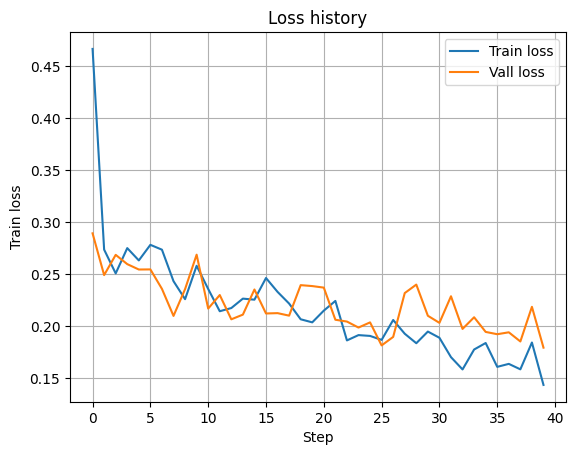

In [507]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history, label = 'Train loss')
plt.plot(test_loss_history, label = 'Vall loss')
plt.legend();

## Точность на тесте

In [480]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in test_loader:
        data = data.to(device)
        labels = labels.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('The final Test Accuracy of the model: {} %'.format((correct / total) * 100))

The final Test Accuracy of the model: 93.31366764995084 %


## Точность на тесте

In [481]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in train_loader:
        data = data.to(device)
        labels = labels.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('The final Test Accuracy of the model: {} %'.format((correct / total) * 100))

The final Test Accuracy of the model: 92.8086642599278 %


#  Выводы
* Подобрана скорость обучения, а так же количество нейронов в дропаут слое позваляющие снизить переобучение
* Увеличение  maxlen определяющие длину вектора сильно на точность не повлияло оптимальные результаты получаются при значении 20-50
* В качестве препроцесинга были удалены теги, имена пользователей, символы не входящие в число буквеных обозначений (смайлики, битая кодировка и прочее) так же были удалены слова из 1 буквы и некоторые из 2х. 
* Препроцесинг в целом можно продолжать и удалить слова не дающие особой смыловой нагрузки такие как - can must, have, try, see etc.